# PTP Measurements
- copy data from measurement node to hp-workstation for evaluation
- e.g., use command:
```shell
rsync -aP node2:/home/ubuntu/ptp/measurement/json/ /home/arch/validation_paper/ptp/measurements/
```

In [1]:
from os import listdir
from json import loads
from pandas import DataFrame, concat, melt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats

In [2]:
PATH = "/home/arch/validation_paper/ptp/measurements"

In [3]:
def read_files():
    files = {"Kontron": [],
             "FibroLAN": []}
    for f in sorted(listdir(PATH)):
        if "json" in f:
            if "Kontron" in f:
                files["Kontron"].append("{}/{}".format(PATH, f))
            elif "FibroLAN" in f:
                files["FibroLAN"].append("{}/{}".format(PATH, f))
    return files

In [4]:
def get_ptp_messages(file, tuple_=True):
    json = []
    for line in open(file, 'r'):
        json.append(loads(line))
    ptp = {}
    ptp["CLK_offset_raw"] = []
    ptp["PATH_delay_raw"] = []
    ptp["CLK_freq_raw"] = []

    for j in json:
        msg = j["MESSAGE"]
        if "CLK_offset_raw" in msg:
            msg = msg.rsplit("CLK_offset_raw")
            ts = float(msg[0][1:-2])
            value = float(msg[1])
            if tuple_:
                ptp["CLK_offset_raw"].append((ts, value))
            else:
                ptp["CLK_offset_raw"].append(value)
        if "PATH_delay_raw" in msg:
            msg = msg.rsplit("PATH_delay_raw")
            ts = float(msg[0][1:-2])
            value = float(msg[1])
            if tuple_:
                ptp["PATH_delay_raw"].append((ts, value))
            else:
                ptp["PATH_delay_raw"].append(value)

    # afterwards, free memory:
    del json

    return ptp

In [5]:
files = read_files()

column_names = ["8", "16", "32", "64", "128"]

dfs = {}

for switch, switch_files in files.items():
    dfs_temp = []
    for f, c in zip(switch_files, column_names):
        ptp = get_ptp_messages(f, tuple_=False)
        if len(ptp["CLK_offset_raw"]) > 0:
            df = DataFrame(ptp["CLK_offset_raw"], columns=["{}".format(c)])
            dfs_temp.append(df)
    df_switch = concat(dfs_temp, axis=1).assign(Switch=switch)
    dfs[switch] = df_switch

    del dfs_temp
    del df_switch

c = concat(dfs)
mdf = melt(c, id_vars=['Switch'], var_name=['SyncInterval'])

In [6]:
dfs["Kontron"].describe()

,8,16,32,64,128
count,25100.000000,47411.000000,85340.000000,142233.000000,213350.000000
mean,0.008725,-0.005758,-0.003609,-0.004936,-0.002962
std,3.552440,3.476159,3.404426,3.370978,3.351997
min,-11.000000,-11.000000,-10.000000,-11.000000,-10.000000
25%,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,2.000000,2.000000,2.000000
max,10.000000,11.000000,10.000000,10.000000,10.000000


In [7]:
dfs["FibroLAN"].describe()

,8,16,32,64,128
count,22590.000000,42670.000000,76805.000000,128008.000000,192012.000000
mean,0.016954,-0.005109,-0.002148,-0.002601,-0.000500
std,3.571289,3.456377,3.430982,3.394973,3.373903
min,-11.000000,-11.000000,-11.000000,-11.000000,-10.000000
25%,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000
max,11.000000,10.000000,10.000000,11.000000,10.000000


In [ ]:
for switch, df in dfs.items():
    print(switch)

    for c in column_names:
        dataframe = df[c].dropna()

        print("Setting: {} Sync Msg/s".format(c))
        print(dataframe.describe())
        print("Median:\t\t", dataframe.median())
        print("p90%:\t\t", dataframe.quantile(0.9))
        print("p95%:\t\t", dataframe.quantile(0.95))
        print("p99%:\t\t", dataframe.quantile(0.99))
        print("p99.9%:\t\t", dataframe.quantile(0.999))
        print("p99.99%:\t", dataframe.quantile(0.9999))
        print("p99.9999%:\t", dataframe.quantile(0.99999))
        print("\n")

In [11]:
mdf

,Switch,SyncInterval,value
0,Kontron,8,-6.0
1,Kontron,8,-5.0
2,Kontron,8,-5.0
3,Kontron,8,-5.0
4,Kontron,8,5.0
...,...,...,...
2026805,FibroLAN,128,4.0
2026806,FibroLAN,128,-5.0
2026807,FibroLAN,128,2.0
2026808,FibroLAN,128,-5.0


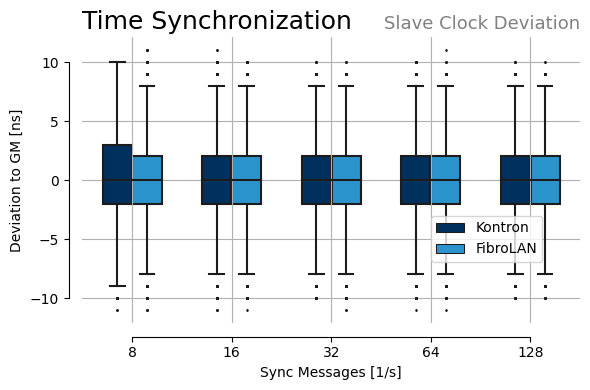

In [47]:
# sns.set_theme()
colors = ["#00305d", "#2C94CC"]
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize=(6, 4))

plt.title("Time Synchronization ", loc='left', fontsize=18)
plt.title("Slave Clock Deviation", loc='right', fontsize=13, color='grey')

sns.boxplot(x="SyncInterval", y="value", hue="Switch", data=mdf, fliersize=1, saturation=1, width=.6)
sns.despine(offset=10, trim=True)

plt.legend(bbox_to_anchor=(0.7, 0.375), loc='upper left', borderaxespad=0)

plt.grid(dict(visible=True,
              which='major',
              color='#CCD6DF',
              linestyle='-'))
plt.grid(dict(visible=True,
              which='minor',
              color='#CCD6DF',
              linestyle='--'))

ax.set_ylabel("Deviation to GM [ns]")
ax.set_xlabel('Sync Messages [1/s]')

plt.tight_layout()

plt.savefig('plot-ptp.png', dpi=300)
plt.show()

In [ ]:
stats = {}
for c in column_names:
    stats[c] = boxplot_stats(df[c].dropna().values)

stats['8']

In [ ]:
boxplot_stats(dfs["Kontron"]["128"].dropna().values)